In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Import dataset
file_path = '/Users/kelly/Desktop/complaints_25Nov21.csv'
complaints_df = pd.read_csv(file_path)


complaints_df_head = complaints_df.head()
complaints_df_info = complaints_df.info()

complaints_df_head, complaints_df_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207260 entries, 0 to 207259
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 207260 non-null  object
 1   Product                       207260 non-null  object
 2   Sub-product                   164245 non-null  object
 3   Issue                         207260 non-null  object
 4   Sub-issue                     10347 non-null   object
 5   Consumer complaint narrative  29391 non-null   object
 6   Company public response       58458 non-null   object
 7   Company                       207260 non-null  object
 8   State                         205066 non-null  object
 9   ZIP code                      197974 non-null  object
 10  Tags                          28265 non-null   object
 11  Consumer consent provided?    51313 non-null   object
 12  Submitted via                 207260 non-null  object
 13 

(  Date received                  Product                   Sub-product  \
 0    2016-10-26          Money transfers  International money transfer   
 1    2015-03-27  Bank account or service    Other bank product/service   
 2    2015-04-20  Bank account or service    Other bank product/service   
 3    2013-04-29                 Mortgage   Conventional fixed mortgage   
 4    2013-05-29                 Mortgage                Other mortgage   
 
                                       Issue Sub-issue  \
 0                  Other transaction issues       NaN   
 1   Account opening, closing, or management       NaN   
 2  Making/receiving payments, sending money       NaN   
 3  Application, originator, mortgage broker       NaN   
 4  Loan modification,collection,foreclosure       NaN   
 
                         Consumer complaint narrative  \
 0  To whom it concerns, I would like to file a fo...   
 1  My name is XXXX XXXX XXXX and huband name is X...   
 2  XXXX 2015 : I called to

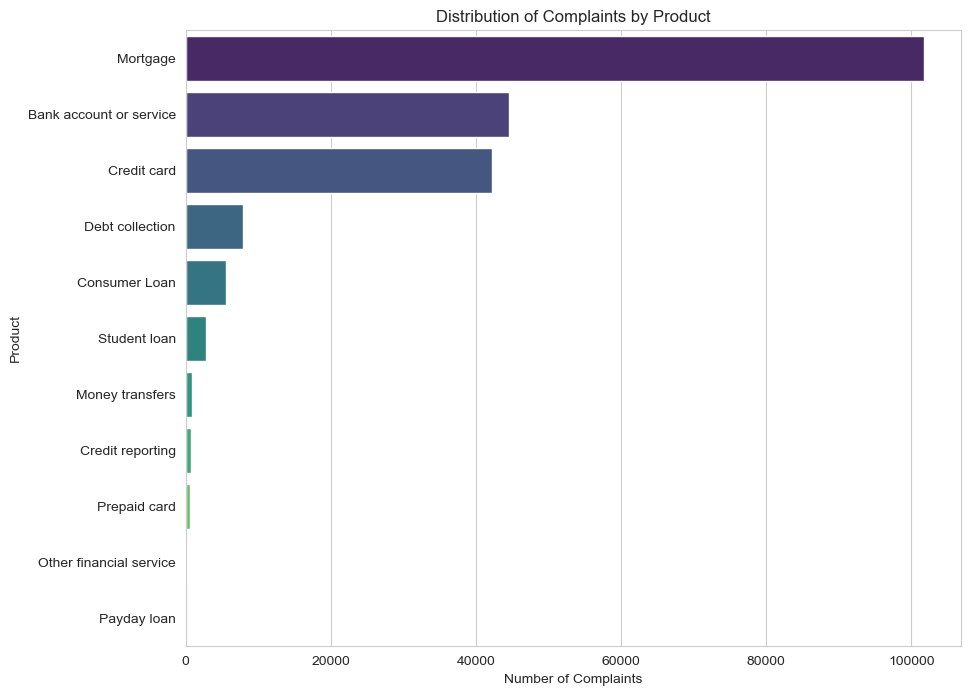

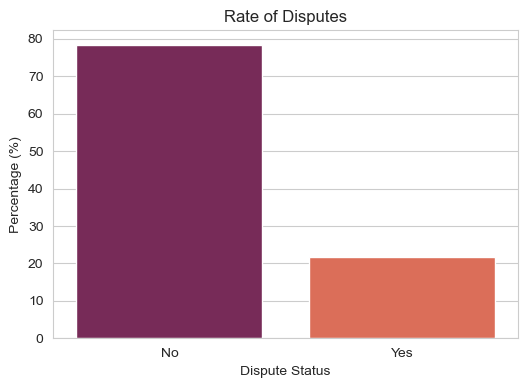

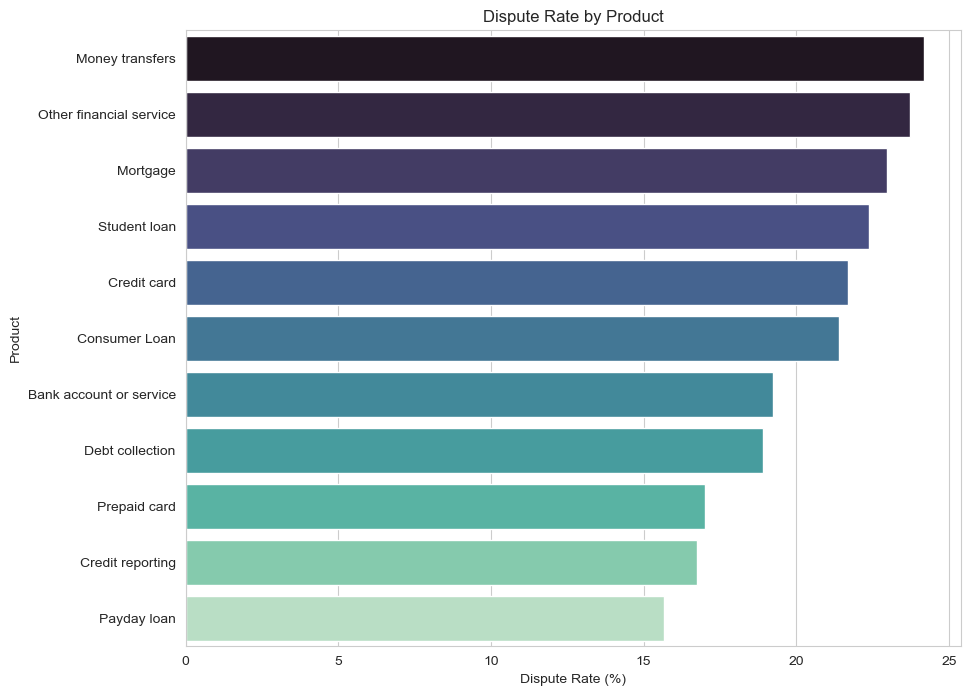

In [38]:
sns.set_style("whitegrid")

#Distribution by product
plt.figure(figsize=(10, 8))
product_counts = complaints_df['Product'].value_counts()
sns.barplot(y=product_counts.index, x=product_counts.values, palette="viridis")
plt.title('Distribution of Complaints by Product')
plt.xlabel('Number of Complaints')
plt.ylabel('Product')
plt.show()

#Rate
dispute_rate = complaints_df['Consumer disputed?'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
sns.barplot(x=dispute_rate.index, y=dispute_rate.values, palette="rocket")
plt.title('Rate of Disputes')
plt.xlabel('Dispute Status')
plt.ylabel('Percentage (%)')
plt.show()

#Dispute rate by product
plt.figure(figsize=(10, 8))
dispute_rate_by_product = complaints_df.groupby('Product')['Consumer disputed?'].apply(lambda x: (x == 'Yes').mean() * 100)
dispute_rate_by_product.sort_values(ascending=False, inplace=True)
sns.barplot(y=dispute_rate_by_product.index, x=dispute_rate_by_product.values, palette="mako")
plt.title('Dispute Rate by Product')
plt.xlabel('Dispute Rate (%)')
plt.ylabel('Product')
plt.show()

In [39]:
#X
X = complaints_df[['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']]

X_encoded = pd.get_dummies(X, drop_first=True)

#Y
le = preprocessing.LabelEncoder()
y = le.fit_transform(complaints_df['Consumer disputed?'])

#Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=123)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((165808, 223), (41452, 223), (165808,), (41452,))

In [40]:
#Checking the proportion
disputed_proportion = (y_train == 1).mean()

#Applying random undersampling when < 30%
if disputed_proportion < 0.30:
    from imblearn.under_sampling import RandomUnderSampler
    
    undersampler = RandomUnderSampler(random_state=123)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
    resampled_proportion = (y_train_resampled == 1).mean()
else:
    X_train_resampled, y_train_resampled = X_train, y_train
    resampled_proportion = disputed_proportion

X_train_resampled.shape, y_train_resampled.shape, resampled_proportion

((71910, 223), (71910,), 0.5)

In [41]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X_train_to_use, y_train_to_use = X_train, y_train

#Train XGBoost Model
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train_to_use, y_train_to_use)

#Predict on test set
y_pred = model_xgb.predict(X_test)

#Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_report_results = classification_report(y_test, y_pred)

accuracy, classification_report_results

(0.7838705008202258,
 '              precision    recall  f1-score   support\n\n           0       0.78      1.00      0.88     32504\n           1       0.41      0.00      0.01      8948\n\n    accuracy                           0.78     41452\n   macro avg       0.60      0.50      0.44     41452\nweighted avg       0.70      0.78      0.69     41452\n')

In [42]:
#Confusion matrix
confusion_matrix_results = confusion_matrix(y_test, y_pred)

classification_report_formatted = "Precision, recall, f1-score, and support for each class:\n\n" + classification_report_results

confusion_matrix_results, classification_report_formatted

(array([[32468,    36],
        [ 8923,    25]]),
 'Precision, recall, f1-score, and support for each class:\n\n              precision    recall  f1-score   support\n\n           0       0.78      1.00      0.88     32504\n           1       0.41      0.00      0.01      8948\n\n    accuracy                           0.78     41452\n   macro avg       0.60      0.50      0.44     41452\nweighted avg       0.70      0.78      0.69     41452\n')

In [54]:
base_case_costs = ((y_test == 0).sum() * 100) + ((y_test == 1).sum() * 600)

base_case_costs

8619200

In [44]:
y_probs = model_xgb.predict_proba(X_test)[:, 1]

#The minimum cost and corresponding threshold
min_cost = float('inf')
best_threshold = 0.5

#Iterate over a range of possible values
for threshold in np.linspace(0, 1, 100):
    y_pred_threshold = (y_probs > threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    
    current_cost = tn * 100 + fp * 190 + fn * 600 + tp * 190
    
    #Update the min & best
    if current_cost < min_cost:
        min_cost = current_cost
        best_threshold = threshold

print(f"Best threshold: {best_threshold}")
print(f"Minimum cost: {min_cost}")

Best threshold: 0.18181818181818182
Minimum cost: 7592760


In [45]:
dispute_proportion_test_set = (y_test == 1).mean()
dispute_proportion_test_set = y_test.sum() / len(y_test)
dispute_proportion_test_set

0.21586413200810575

In [46]:
dispute_proportion_resampled_train_set = (y_train_resampled == 1).mean()
dispute_proportion = y_train_resampled.sum() / len(y_train_resampled)
dispute_proportion_resampled_train_set

0.5

In [51]:
y_probs = model_xgb.predict_proba(X_test)[:, 1]

min_cost = float('inf')
best_threshold = None

#Find the lowest cost
for threshold in np.linspace(0, 1, 101):
    y_pred_threshold = y_probs > threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    current_cost = tn * 100 + fp * 190 + fn * 600 + tp * 190
    
    #Update the minimum & best
    if current_cost < min_cost:
        min_cost = current_cost
        best_threshold = threshold

print(f"Lowest total cost: {min_cost} at threshold: {best_threshold}")

Lowest total cost: 7589900 at threshold: 0.19
